# Player Salary Prediction

## Data Manipulation and Visualization

### Importing packages and examining data

In [1]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Read the data into a pandas dataframe
data = pd.read_csv('baseball-salaries.csv')
# Examine first few rows of data
data.head()

,salary,ba,obp,runs,hits,doubles,triples,hr,rbi,bb,so,sb,e,fa,fa9192,arb,arb9192,player
0,3300,0.272,0.302,69,153,21,4,31,104,22,80,4,3,YES,NO,NO,NO,Andre Dawson
1,2600,0.269,0.335,58,111,17,2,18,66,39,69,0,3,YES,YES,NO,NO,Steve Buchele
2,2500,0.249,0.337,54,115,15,1,17,73,63,116,6,5,YES,NO,NO,NO,Kal Daniels
3,2475,0.260,0.292,59,128,22,7,12,50,23,64,21,21,NO,NO,YES,NO,Shawon Dunston
4,2313,0.273,0.346,87,169,28,5,8,58,70,53,3,8,NO,NO,YES,NO,Mark Grace


In [10]:
# Check data types
data.dtypes

salary       int64
ba         float64
obp        float64
runs         int64
hits         int64
doubles      int64
triples      int64
hr           int64
rbi          int64
bb           int64
so           int64
sb           int64
e            int64
fa          object
fa9192      object
arb         object
arb9192     object
player      object
dtype: object

There are several things to notice about the data.  For one, the four indicator features that tell a player's contract status are text instead of numerical.  We will need to convert these into integers.  The players column is useful for visualization or analysis later, but is not necessary in modeling and can be stripped.

Since this data consists of players who played at least one game in each season, there may be enormous differences in these counting statistics.  Playing more games is more valuable than not, but some players may be hindered by the fact that they were injured or called up later in the year.  Some players may have benefited from playing many games on a bad team and accumulated counting stats without actually being very good.

Thus, we will compute number of at bats and plate appearances given the batting average and on base percentage nubmers (HBP is not included, so PA will be underestimated). We can then find rate stats like doubles per plate appearance, stolen bases per chance*, or slugging percentage. 

Errors is included in this data; it is also a counting stat and has a similar problem, but there is no way to find the equivalent rate stat (errors per chance) given this data. Knowing that errors may be an unreliable feature, we will attempt to build a model both using errors and also omitting it to see if there is a substantial difference in generalizability and accuracy.  

Runs is a counting stat as well. Converting it to a stat of runs per plate appearance is really not very valuable since the fact that a player scored a run is not entirely his own doing.  Scoring many runs means a player is good at getting on base, but we already have on base percentage to measure that.  On the other hand, scoring runs is seen as valuable and could result in a player getting a higher salary.  We will treat it like errors and check if it adds to the model.

It is also important that we are basing the model off of reliable data. If a player played only a few games, it would be very challenging to accurately assess his value.  I don't know what a reasonable at bat number would be for the cut-off, so we will try building the model with different cut-offs to see if we can arrive at the best model with the best data.  Since a player receives roughly 4 PA per game and there are 162 games in the season, my guess is that 160 might be an okay cut-off for plate appearances (about 1/4 of the season).

\**We cannot get precisely stolen bases per chance, because it is not known the number of times a player is on first base or second base.  This will be defined as number of stolen bases per times on first base.  Time on first base will be defined as number of singles and walks.  This is not entirely accurate because a player could reach first and be pinch run for, could advance to 2nd on an error, or could get thrown out at second after achieving a single.  Given the data, this will have to do, and is probably a better measure than purely the count of stolen bases. A player can technically steal third or home, but these happen rarely enough that we will assume that all stolen bases were steals of second. Ideally we would have caught stealing numbers so we can get stolen base per attempt as well.*



### Create rate stats

In [11]:
# Compute at bats and plate appearances (will be a decimal since missing info)
data['ab'] = data['hits'] / data['ba']
data['pa'] = (data['hits'] + data['bb']) / data['obp']

# Compute number of singles
data['singles'] = data['hits'] - (data['doubles'] + data['triples'] + data['hr'])

# Compute slugging percentage
data['slg'] = (data['singles'] + 2*data['doubles'] + 3*data['triples'] + 4*data['hr']) / data['ab']

# Compute rate of all counting stats
data['Rsingles'] = data['singles'] / data['pa']
data['Rdoubles'] = data['doubles'] / data['pa']
data['Rtriples'] = data['triples'] / data['pa']
data['Rhr'] = data['hr'] / data['pa']
data['Rrbi'] = data['rbi'] / data['pa']
data['Rbb'] = data['bb'] / data['pa']
data['Rso'] = data['so'] / data['pa']

# Compute stolen base per chance
data['Rsb'] = data['sb'] / (data['singles'] + data['bb'])

### Create advanced metrics

In [12]:
# Runs created (Simple version)
data['runs_created'] = data['obp'] * data['slg'] * data['ab']

# BABIP (without sac fly)
data['babip'] = (data['hits'] - data['hr']) / (data['ab'] - data['so'] - data['hr'])

# OPS+ (comparing players to other players)
data['ops'] = data['obp'] + data['slg']
data['ops_plus'] = (data['ops'] / data['ops'].mean())*100
data.drop('ops', axis=1, inplace=True)

### Remove colinear columns

In [13]:
# Create copy of data without colinear columns
colinear_columns = ['ab', 'hits', 'singles', 'doubles', 'triples', 'hr',
                   'rbi', 'bb', 'so', 'sb']

working_data = data.drop(colinear_columns, axis=1)

### Clean up data types

In [14]:
### Remove player name
working_data = working_data.drop('player', axis=1)

### Convert object columns to ints
# Get list of column names
obj_columns = working_data.columns[working_data.dtypes=='object'].tolist()
# Convert column to 1/0
for column in obj_columns:
    working_data[column] = working_data[column].map({'YES':1, 'NO':0})

## Visualization

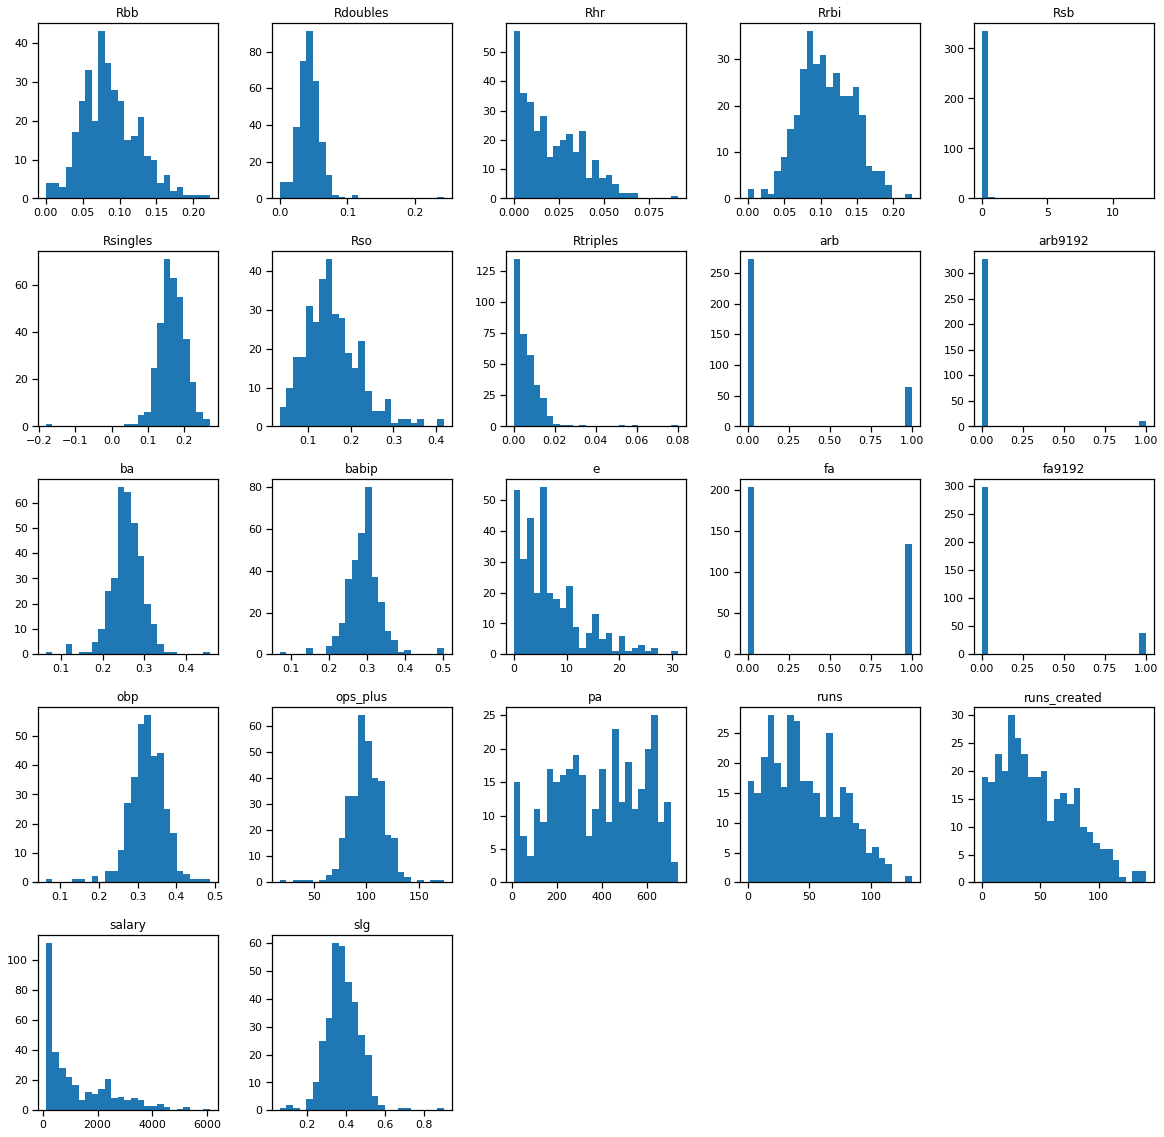

In [15]:
# Visualize histograms of variables
axList = working_data.hist(grid=False, figsize=(20,20), bins=25)

In [30]:
working_data.loc[working_data['Rbb'] > 0, 'Rbb'].min()
#sns.distplot(np.log(working_data['Rbb']))

0.008741935483870969

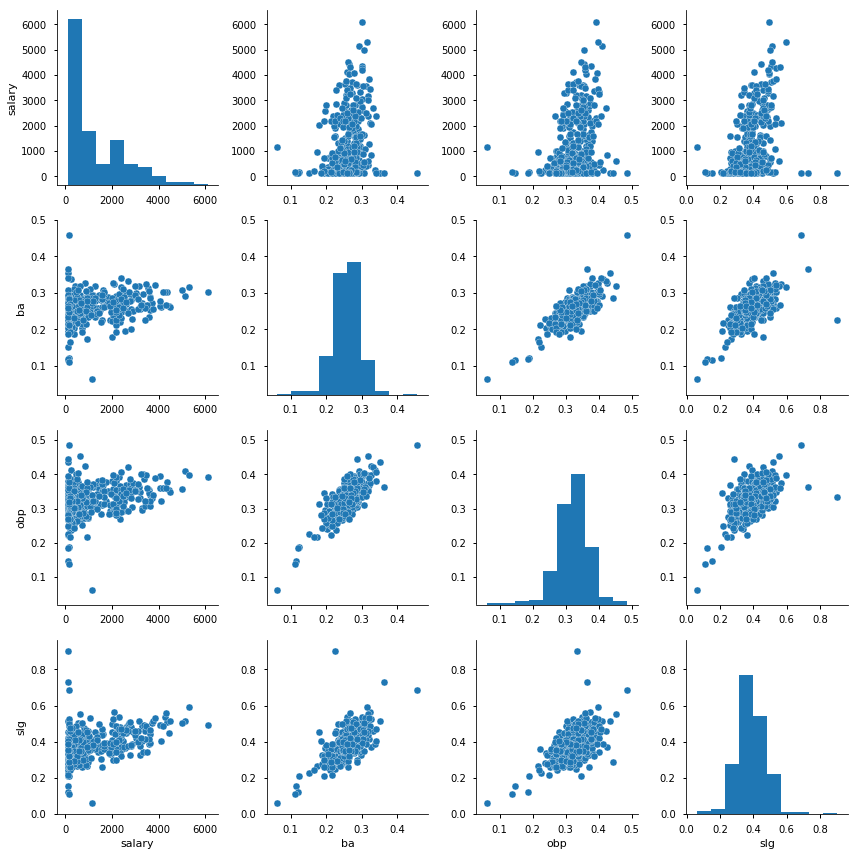

In [9]:
# Visualize pairplots
# First look at basic rate stats
columns = [ 'salary', 'ba', 'obp', 'slg']
sns.pairplot(working_data[columns], size=3)

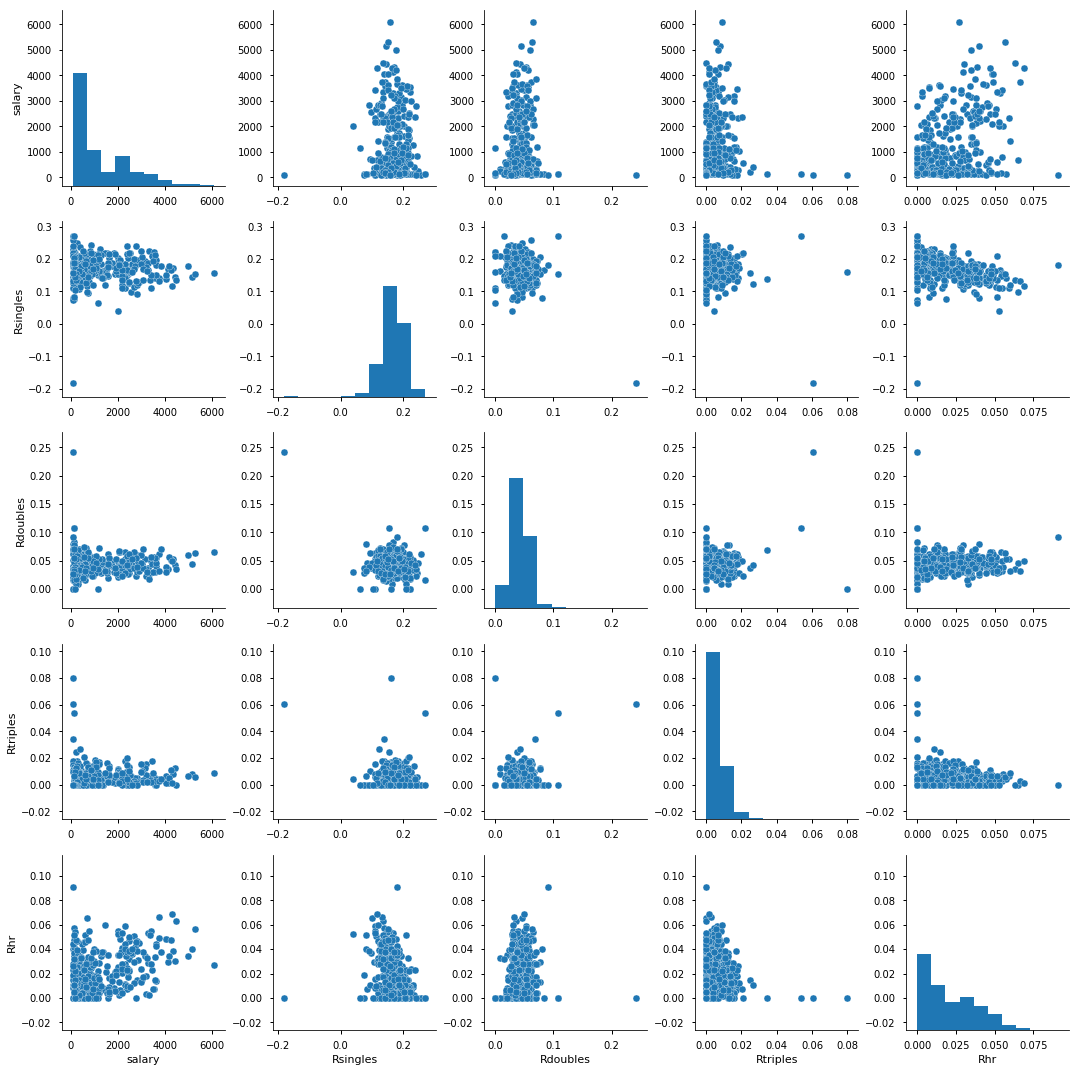

In [10]:
# Next look at hit type rates
columns = ['salary', 'Rsingles', 'Rdoubles', 'Rtriples', 'Rhr']
sns.pairplot(working_data[columns], size=3)

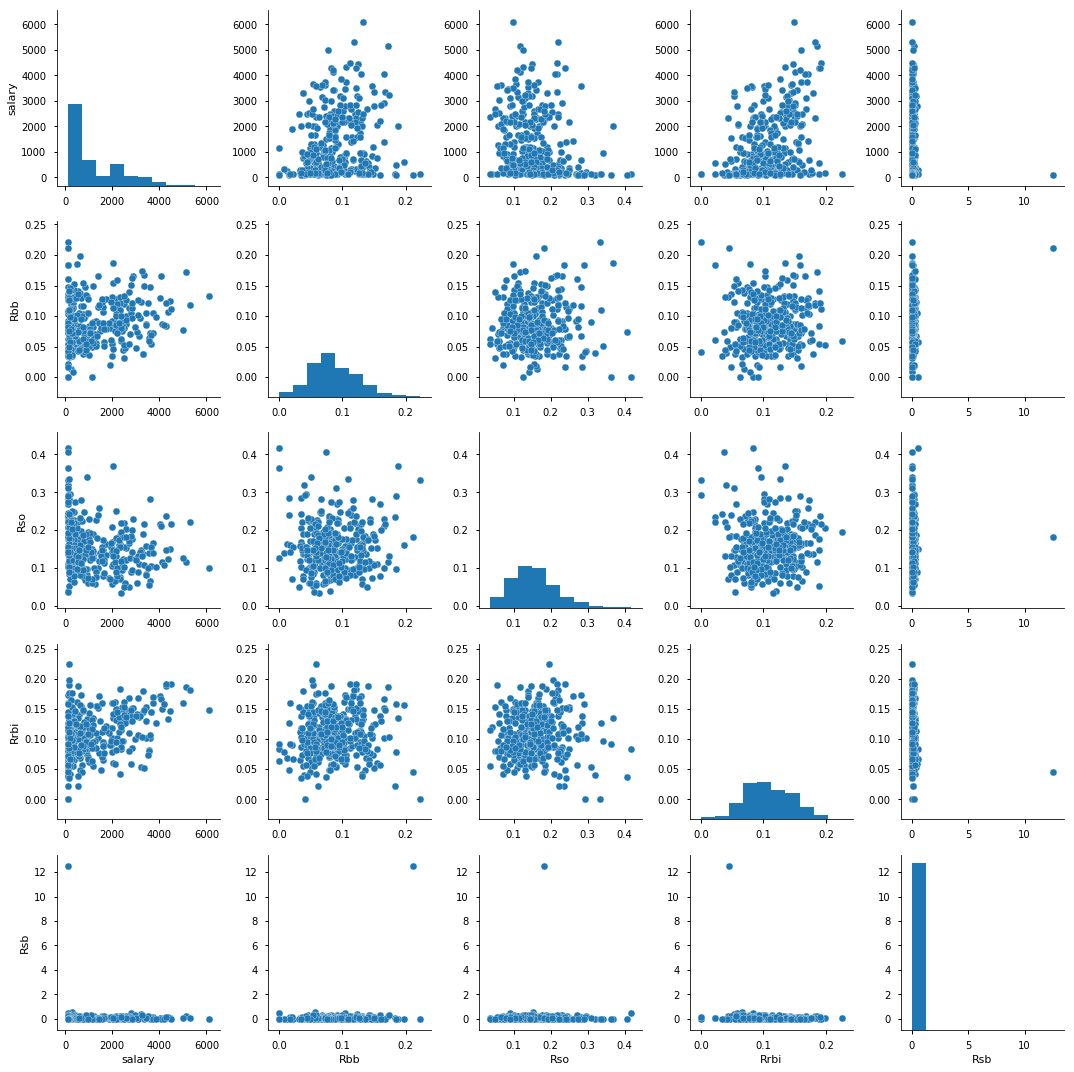

In [11]:
# Next look at other rate stats
columns = ['salary', 'Rbb', 'Rso', 'Rrbi', 'Rsb']
sns.pairplot(working_data[columns], size=3)

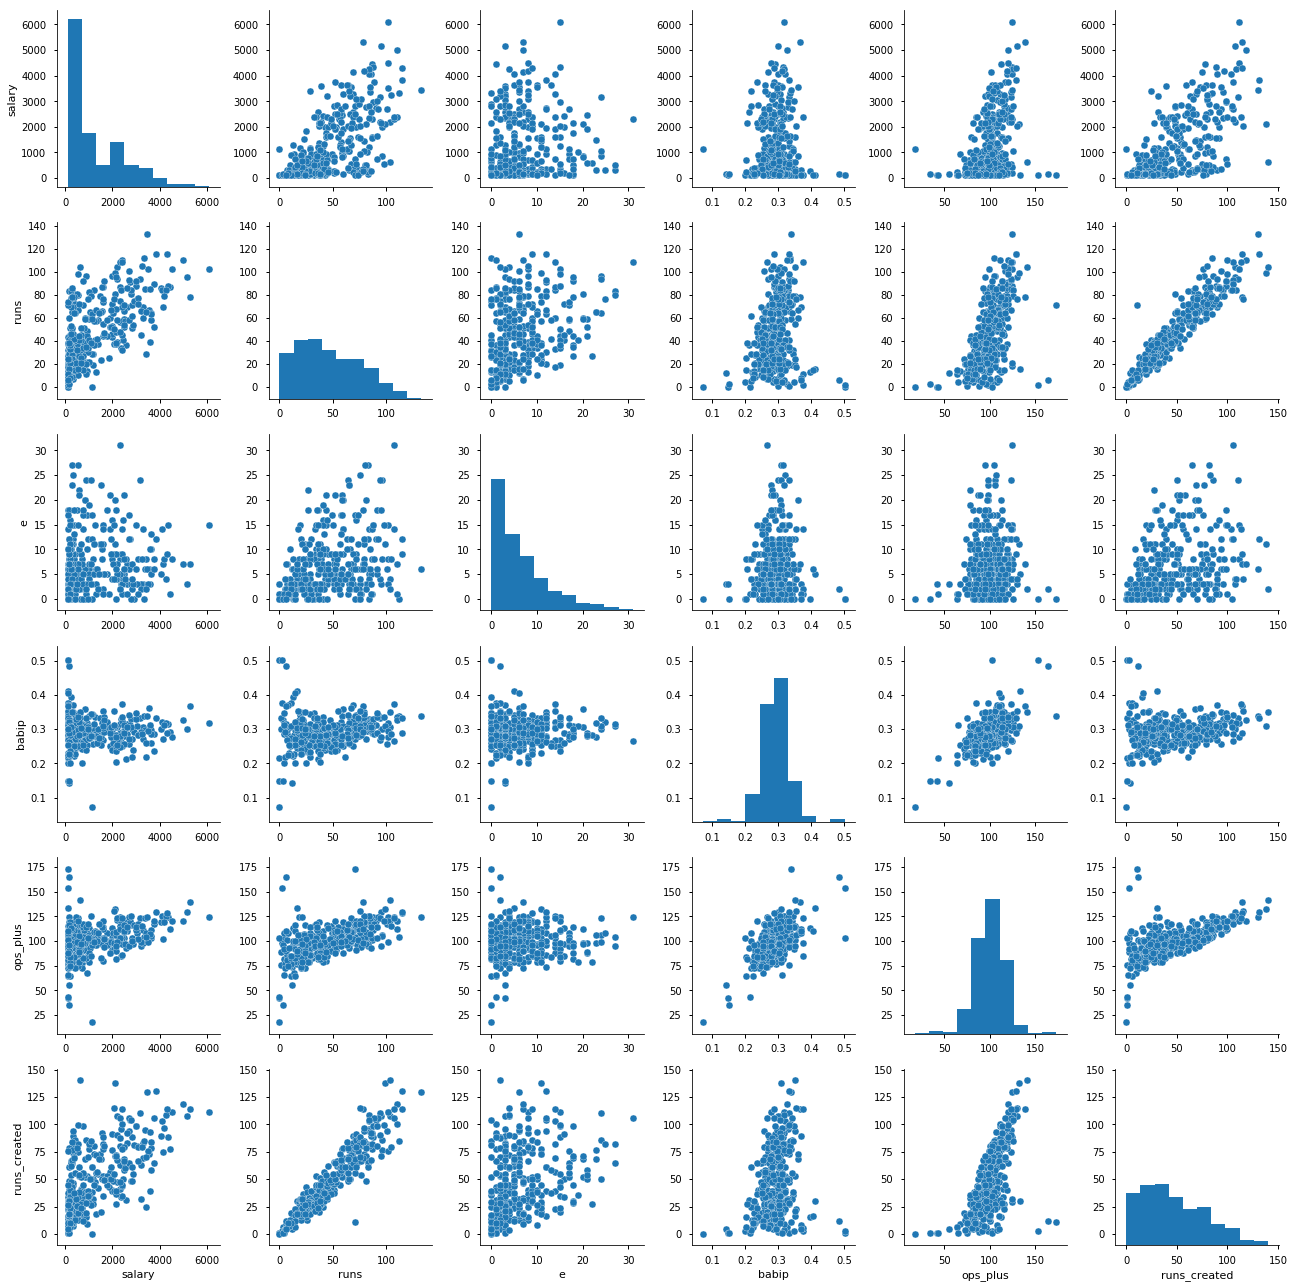

In [12]:
# Next look at runs, errors, and advanced metrics
columns = ['salary', 'runs', 'e', 'babip', 'ops_plus', 'runs_created']
sns.pairplot(working_data[columns], size=3)

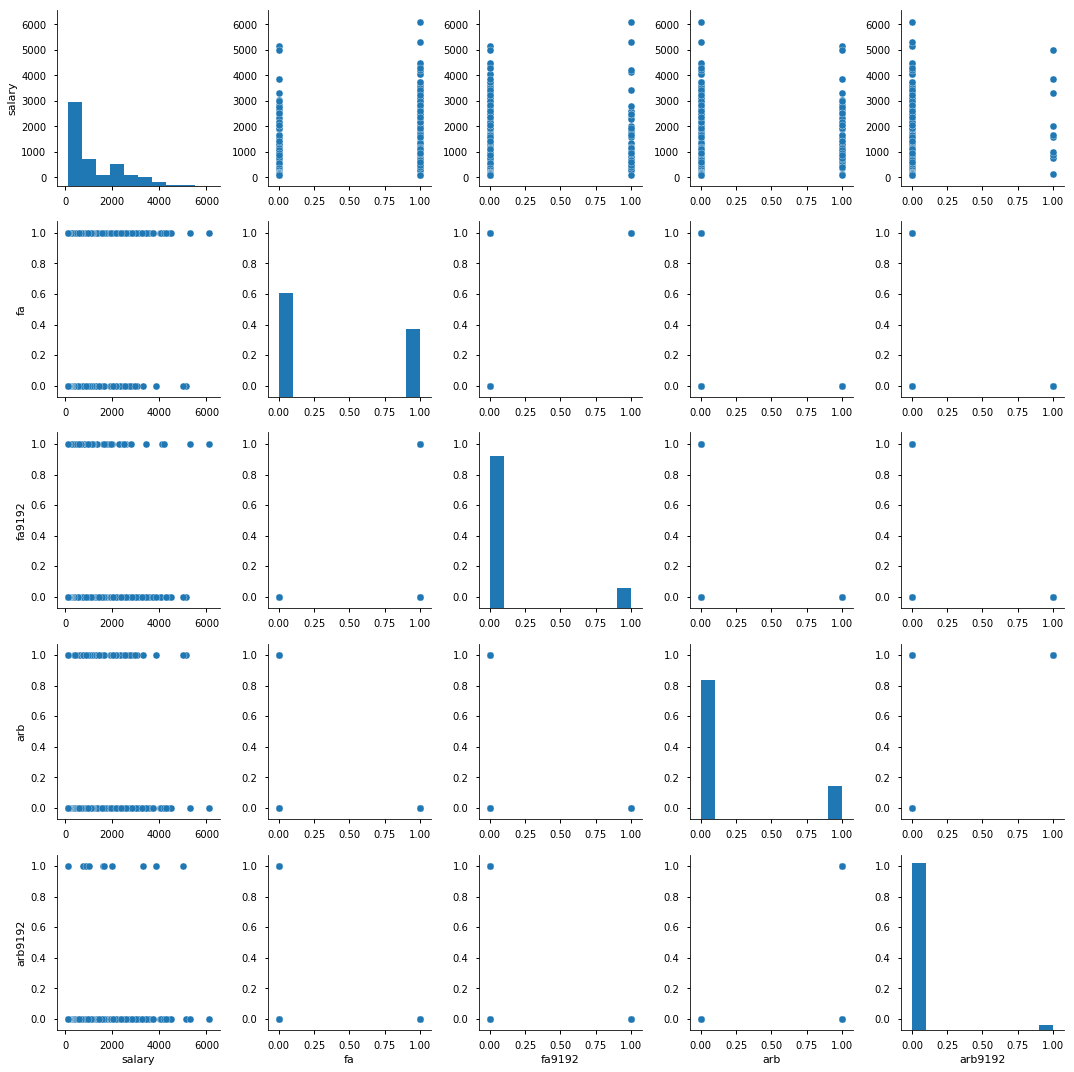

In [13]:
# Finally look at the free agent stats
columns = ['salary', 'fa', 'fa9192', 'arb', 'arb9192']
sns.pairplot(working_data[columns], size=3)

# Modeling

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

## Splitting data into train and test sets

The data will be split into train and test sets.  The test set will be 20% of the entire dataset.  We will also run the model with the following scenarios:
* Plate Appearance cutoffs of 0, 40, 80, 160, 240
* With and without errors
* With and without runs

In [15]:
pa_cutoffs = [0, 40, 80, 160, 240]

pa_scores_dict = {'LR':[],
              'RF':[],
              'MLP':[]}

### Linear Regression

In [16]:
LR = LinearRegression()

for cutoff in pa_cutoffs:
    y = working_data.loc[working_data['pa'] >= cutoff, 'salary']
    X = working_data[working_data['pa'] >= cutoff].drop('salary', axis=1)
    LR_score = []
    for i in range(20):
        # Split into train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        # Train linear regression on train set and compute score on test set
        LR_pred = LR.fit(X_train, y_train).predict(X_test)
        LR_score.append(mean_squared_error(y_test, LR_pred))
        
    
    pa_scores_dict['LR'].append(np.mean(LR_score))

### Random Forest

In [17]:
# Find the best parameters with grid search
RF_params = {'n_estimators':[10, 25, 100],
            'max_depth':[10, 20, None],
            'min_samples_split':[2, 3, 10],
            'min_samples_leaf':[1, 3, 10]}

RF_best_params = {}

In [18]:
for cutoff in pa_cutoffs:
    y = working_data.loc[working_data['pa'] >= cutoff, 'salary']
    X = working_data[working_data['pa'] >= cutoff].drop('salary', axis=1)
    RF = RandomForestRegressor()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)    
    RF_grid_search = GridSearchCV(RF, RF_params)
    RF_pred = RF_grid_search.fit(X_train, y_train).predict(X_test)
    
    best_index = int(np.flatnonzero(RF_grid_search.cv_results_['rank_test_score'] == 1))
    RF_best_params[cutoff] = RF_grid_search.cv_results_['params'][best_index]

    RF_score = mean_squared_error(y_test, RF_pred)
    pa_scores_dict['RF'].append(RF_score)

### Neural Network

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [38]:
import warnings
from time import time
warnings.filterwarnings('ignore')

In [39]:
# Find the best parameters with grid search
layer_sizes = []
for i in range(1, 21):
    layer_sizes.append((i*5,))

MLP_params = {'hidden_layer_sizes':layer_sizes,
             'activation':['identity', 'logistic', 'tanh', 'relu'],
             'solver':['lbfgs', 'sgd', 'adam'],
             'alpha':[0.000001, 0.00001, 0.0001, 0.001, 0.01]}

MLP_best_params = {}

In [40]:
for cutoff in pa_cutoffs:
    start = time()
    y = working_data.loc[working_data['pa'] >= cutoff, 'salary']
    X = working_data[working_data['pa'] >= cutoff].drop('salary', axis=1)
    # Scale data to get best results from neural network
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    MLP = MLPRegressor(max_iter = 10000, random_state = 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    MLP_random_search = RandomizedSearchCV(MLP, MLP_params, n_iter=20)
    MLP_pred = MLP_random_search.fit(X_train, y_train).predict(X_test)
    
    best_index = int(np.flatnonzero(MLP_random_search.cv_results_['rank_test_score'] == 1))
    MLP_best_params[cutoff] = MLP_random_search.cv_results_['params'][best_index]
    
    MLP_score = mean_squared_error(y_test, MLP_pred)
    pa_scores_dict['MLP'].append(MLP_score)
    
    print('{} Cutoff is complete.  {}'.format(cutoff, time()-start))

0 Cutoff is complete.  194.20521807670593
40 Cutoff is complete.  198.03448915481567
80 Cutoff is complete.  203.6858401298523
160 Cutoff is complete.  158.67183899879456
240 Cutoff is complete.  162.27307796478271


### Examine Results of Cutoffs

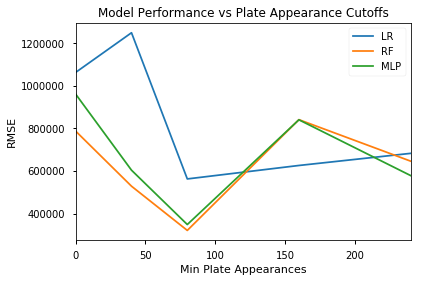

In [50]:
# Create Dataframe
pa_scores_dict['cutoff'] = pa_cutoffs
cutoff_df = pd.DataFrame(pa_scores_dict)

# Plot Cutoff Results
fig, ax = plt.subplots()

cutoff_df.plot(x="cutoff", y=["LR", "RF", "MLP"], ax=ax)

plt.ylabel('RMSE')
plt.xlabel('Min Plate Appearances')
plt.title('Model Performance vs Plate Appearance Cutoffs')
plt.show()

It is clear that 80 plate appearances is the best cutoff for all models.  This must be the best tradeoff between having reliable data while still having a strong sample size.

Both the Random Forest model and Neural Network model outperform the linear model.  

##  Check Contribution of errors and runs

In [95]:
from sklearn.model_selection import cross_val_score

### Get best params from Random Forest and Neural Network
RF_params = RF_best_params[80]
MLP_params = MLP_best_params[80]
MLP_params['max_iter'] = 10000
MLP_params['random_state'] = 0

In [136]:
options = ['', ['e'], ['runs'], ['e', 'runs']]
option_labels = ['Keep Both', 'Drop Errors', 'Drop Runs', 'Drop Both']
variable_scores_dict = {'LR':[],
                      'RF':[],
                      'MLP':[]}

In [140]:
cutoff = 80
y = working_data.loc[working_data['pa'] >= cutoff, 'salary']

for option in options:
    exclude = ['salary']
    if option:
        exclude.extend(option)
    # Remove column from option
    X = working_data[working_data['pa'] >= cutoff].drop(exclude, axis=1)
    # Scale data for MLP
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Initiate models
    LR = LinearRegression()
    RF = RandomForestRegressor(**RF_params)
    MLP = MLPRegressor(**MLP_params)
    
    # Train models and find score
    LR_scores = cross_val_score(LR, X, y, cv=5)
    RF_scores = cross_val_score(RF, X, y, cv=5)
    MLP_scores = cross_val_score(MLP, X_scaled, y, cv=5)

    # Add average score to dictionary
    variable_scores_dict['LR'].append(np.mean(LR_scores))
    variable_scores_dict['RF'].append(np.mean(RF_scores))
    variable_scores_dict['MLP'].append(np.mean(MLP_scores))

### Examine Results of Variables

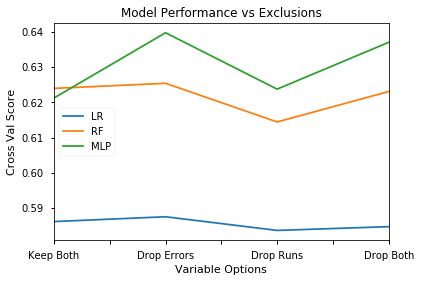

In [149]:
# Create Dataframe
variable_scores_dict['options'] = option_labels
variable_df = pd.DataFrame(variable_scores_dict)

# Plot Variable Exclude Results
fig, ax = plt.subplots()

variable_df.plot(x="options", y=["LR", "RF", "MLP"], ax=ax)

plt.ylabel('Cross Val Score')
plt.xlabel('Variable Options')
plt.title('Model Performance vs Exclusions')
plt.show()

It is clear that removing errors from the data benefits the model's ability to predict on unseen data.  Runs, however, has more predictive power.

## Final Model Selection

In [163]:
# Create dataset that drops errors and only has players with at least 80 plate appearances
final_data = working_data[working_data['pa'] >= cutoff].drop('e', axis=1)
y = final_data['salary']
X = final_data.drop(['salary'], axis=1)

In [164]:
# Separate into a train and test set randomly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train all 3 models
LR_final = LinearRegression()
RF_final = RandomForestRegressor(**RF_params)
MLP_final = MLPRegressor(**MLP_params)

LR_pred = LR_final.fit(X_train, y_train).predict(X_test)
LR_score = mean_squared_error(y_test, LR_pred)

RF_pred = RF_final.fit(X_train, y_train).predict(X_test)
RF_score = mean_squared_error(y_test, RF_pred)

MLP_pred = MLP_final.fit(X_train_scaled, y_train).predict(X_test_scaled)
MLP_score = mean_squared_error(y_test, MLP_pred)

In [168]:
results = pd.DataFrame({'Model':['Linear Regression', 'Random Forest', 'Neural Network'],
                       'RMSE':[LR_score, RF_score, MLP_score]})
results

,Model,RMSE
0,Linear Regression,368099.279829
1,Random Forest,353794.640483
2,Neural Network,372936.988701


In [173]:
importance = RF_final.feature_importances_
features = X.columns.tolist()
feature_df = pd.DataFrame({'features':features,
                          'importance':importance})

feature_df.sort_values('importance', inplace=True, ascending=False)



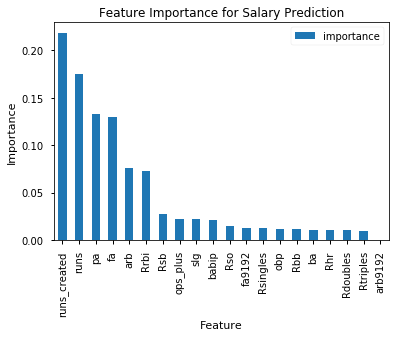

In [176]:
# Plot Feature Importance
fig, ax = plt.subplots()

feature_df.plot(x="features", y='importance', kind='bar', ax=ax)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance for Salary Prediction')
plt.show()

In [203]:
# Check accuracy
accuracy_df = pd.DataFrame({'actual':y_test,
                           'predicted':RF_pred})

accuracy_df['difference'] = accuracy_df['predicted'] - accuracy_df['actual']

labels = []
for i in range(len(RF_pred)):
    if abs(RF_pred[i] - y_test.iloc[i]) < 50:
        labels.append('<$50k')
    elif abs(RF_pred[i] - y_test.iloc[i]) < 100:
        labels.append('$50k - $100k')
    elif abs(RF_pred[i] - y_test.iloc[i]) < 250:
        labels.append('$100k - $250k')
    elif abs(RF_pred[i] - y_test.iloc[i]) < 500:
        labels.append('$250k - $500k')
    else:
        labels.append('>$500k')

accuracy_df['labels'] = labels

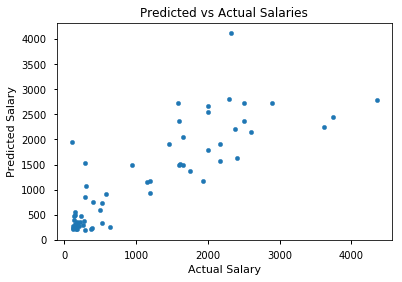

In [190]:

fig, ax = plt.subplots()

accuracy_df.plot(x="actual", y='predicted', kind='scatter', ax=ax)

plt.ylabel('Predicted Salary')
plt.xlabel('Actual Salary')
plt.title('Predicted vs Actual Salaries')
plt.show()

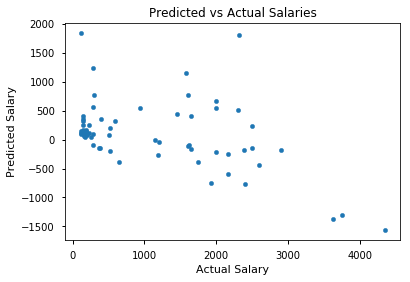

In [191]:

fig, ax = plt.subplots()

accuracy_df.plot(x="actual", y='difference', kind='scatter', ax=ax)

plt.ylabel('Error of Predicted Salary')
plt.xlabel('Actual Salary')
plt.title('Predicted vs Actual Salaries')
plt.show()

In [209]:
accuracy_df['labels'].value_counts()

$100k - $250k    24
>$500k           17
$250k - $500k    12
$50k - $100k      6
<$50k             4
Name: labels, dtype: int64